### The code is modified from [here](https://keras.io/examples/vision/siamese_network/)

In [51]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [52]:
batch_size = 16
margin = 1  # Margin for constrastive loss.

In [3]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")

In [4]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((300, 1))
# x = tf.keras.layers.BatchNormalization()(input)
# x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
# x = layers.AveragePooling2D(pool_size=(2, 2))(x)
# x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
# x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(input)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((300, 1))
input_2 = layers.Input((300, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [5]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [53]:
X = np.load('X.npy')
Y = np.load('Y.npy')

X = X.astype("float32")
Y = Y.astype("uint8")

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=66)

In [7]:
B = np.load('B.npy').tolist()
M = np.load('M.npy').tolist()

In [8]:
pairs_train, labels_train = make_pairs(X_train, Y_train)
pairs_test, labels_test = make_pairs(X_test, Y_test)

In [14]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]
print(len(x_train_1))

x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (20000, 28, 28)
x_test_2 = pairs_test[:, 1]
print(len(x_test_1))

1008
432


In [43]:
input = layers.Input((300, 1))

x = layers.Flatten()(input)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((300, 1))
input_2 = layers.Input((300, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 300, 1)]     0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 300, 1)]     0                                            
__________________________________________________________________________________________________
model_18 (Functional)           (None, 10)           4210        input_29[0][0]                   
                                                                 input_30[0][0]                   
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 1)            0           model_18[0][0]            

In [44]:
n = 50
history = siamese.fit(
    [x_train_1[:n], x_train_2[:n]],
    labels_train[:n],
    batch_size=batch_size,
    epochs=500,
)

Epoch 1/500
4/4 [==============================] - 1s 5ms/step - loss: 0.3409 - accuracy: 0.4200
Epoch 2/500
4/4 [==============================] - 0s 6ms/step - loss: 0.2665 - accuracy: 0.5200
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 0.2302 - accuracy: 0.6000
Epoch 4/500
4/4 [==============================] - 0s 4ms/step - loss: 0.1858 - accuracy: 0.7000
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 0.2112 - accuracy: 0.6000
Epoch 6/500
4/4 [==============================] - 0s 4ms/step - loss: 0.2569 - accuracy: 0.5600
Epoch 7/500
4/4 [==============================] - 0s 4ms/step - loss: 0.2186 - accuracy: 0.6200
Epoch 8/500
4/4 [==============================] - 0s 5ms/step - loss: 0.2119 - accuracy: 0.6800
Epoch 9/500
4/4 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.87 - 0s 3ms/step - loss: 0.1994 - accuracy: 0.7400
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 0.1429 - accu

4/4 [==============================] - 0s 4ms/step - loss: 0.0761 - accuracy: 0.9000
Epoch 167/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0313 - accuracy: 1.0000
Epoch 168/500
4/4 [==============================] - 0s 7ms/step - loss: 0.0550 - accuracy: 0.9600
Epoch 169/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0420 - accuracy: 0.9800
Epoch 170/500
4/4 [==============================] - 0s 6ms/step - loss: 0.0530 - accuracy: 0.9600
Epoch 171/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0466 - accuracy: 0.9600
Epoch 172/500
4/4 [==============================] - 0s 4ms/step - loss: 0.0409 - accuracy: 0.9800
Epoch 173/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0327 - accuracy: 1.0000
Epoch 174/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0585 - accuracy: 0.9600
Epoch 175/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0570 - accuracy: 0.9600
Epoch 176/500
4/4 [=====

4/4 [==============================] - 0s 3ms/step - loss: 0.0307 - accuracy: 0.9800
Epoch 331/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0363 - accuracy: 0.9800
Epoch 332/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0301 - accuracy: 0.9800
Epoch 333/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0230 - accuracy: 1.0000
Epoch 334/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0262 - accuracy: 0.9800
Epoch 335/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0159 - accuracy: 1.0000
Epoch 336/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0246 - accuracy: 1.0000
Epoch 337/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9000
Epoch 338/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0404 - accuracy: 0.9600
Epoch 339/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0514 - accuracy: 0.9400
Epoch 340/500
4/4 [=====

4/4 [==============================] - 0s 3ms/step - loss: 0.0383 - accuracy: 0.9800
Epoch 495/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0281 - accuracy: 0.9800
Epoch 496/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0321 - accuracy: 0.9800
Epoch 497/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0339 - accuracy: 0.9800
Epoch 498/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0087 - accuracy: 1.0000
Epoch 499/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0217 - accuracy: 0.9600
Epoch 500/500
4/4 [==============================] - 0s 3ms/step - loss: 0.0262 - accuracy: 0.9800


In [45]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

14/14 [==============================] - 0s 2ms/step - loss: 0.2223 - accuracy: 0.6944
test loss, test acc: [0.22225452959537506, 0.6944444179534912]


In [46]:
predictions = siamese.predict([x_train_1[:1], x_train_2[:1]])
predictions

array([[0.01696607]], dtype=float32)

After the siamese network detector is trained, I try to generate AE sample

In [47]:
def x_in_y(query, base):
    l = len(query)
    for i in range(len(base)):
        if base[i:i+l] == query:
            return True
    return False

def F(d, ng):
    # 分母: len(d)
    count = 0
    for seq in d:
        if x_in_y(ng, seq):
            count += 1
    return count / float(len(d))

In [48]:
import matplotlib.pyplot as plt
l = 300

def feature_level_attack(model, x, A, total_round = 10):
    # model: trained model detector
    # x: input api sequence with length l
    # A: set of api call
    r = 1 # round 
    x_star = x
    
    class_prob = []
    
    prediction = model.predict([x_star.reshape(1, -1), X[-22].reshape(1, -1)])
    while(prediction.round() == 1):
        print('round ', r)
        r += 1
        
        i = np.random.randint(0, l-1)
        max_F = 0
        max_idx = 0
        for idx in range(len(A)):
            f = F(B, [x_star[0, i]] + [idx]) - F(M, [x_star[0, i]] + [idx])
            print(f)
            if f > max_F:
                print(f, max_F)
                max_F = f
                max_idx = idx
                
        
        x_star = np.concatenate((x_star[0, 1:i], [max_idx], x_star[0, i:])).reshape(1, -1)
        print([x_star])

        prediction = model.predict([x_star.reshape(1, -1), X[-1].reshape(1, -1)])
        class_prob.append(prediction[0][0])
        print(prediction)
        
        # If the loop doesn't stop after r round, just exit.
        if r == (total_round + 1):
            break
    plt.plot(np.arange(len(class_prob)) + 1, class_prob)
    plt.show()
    return x_star

round  1
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

[[0.97761226]]
round  4
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

[[0.977636]]
round  7
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

[[0.9769652]]
round  10
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

[[0.9629309]]
round  13
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

[[0.97759753]]
round  16
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

[[0.9775173]]
round  19
-0.016666666666666666
0.0
0.0
0.0
0.0
0.0
0.0
0.0033333333333333335
0.0033333333333333335 0
0.0
0.0
0.0
-0.8714285714285714
0.0
0.0033333333333333335
0.0
-0.007142857142857143
-0.003333333333333334
-0.8514285714285714
-0.004761904761904762
0.0
0.0
-0.02142857142857143
-0.014285714285714285
-0.02142857142857143
-0.002380952380952381
0.0
0.48952380952380947
0.48952380952380947 0.0033333333333333335
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.13238095238095238
0.0
0.0
0.7295238095238095
0.7295238095238095 0.48952380952380947
-0.002380952380952381
0.0
0.0
-0.002380952380952381
-0.007142857142857143
-0.01714285714285714
-0.05904761904761905
0.0
-0.10380952380952381
-0.007142857142857143
0.0
0.0
-0.002380952380952381
0.0
-0.016666666666666666
0.0
0.0
0.0
0.0
0.0033333333333333335
0.0009523809523809524
-0.009523809523809525
0.0
0.0
-0.02142857142857143
-0.07857142857142857
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.

[[0.977605]]
round  22
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


[[0.97760576]]
round  25
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

[[0.97760355]]
round  28
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

[[0.9776161]]
round  31
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

[[0.9769236]]
round  34
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

[[0.97751486]]
round  37
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

[[0.9776264]]
round  40
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
0.0
-0.002380952380952381
0.3128571428571429
0.3128571428571429 0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.02095238095238095
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
-0.03333333333333333
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0014285714285714288
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[array([[ 59.,  17.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,

[[0.9774575]]
round  43
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

[[0.9776306]]
round  46
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

[[0.97758234]]
round  49
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

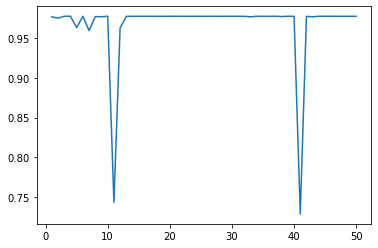

In [50]:
x = feature_level_attack(siamese, X_train[1].reshape(1, -1), np.arange(160), 50)

round  1
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

round  10
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.6533333333333333
0.6533333333333333 0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.006666666666666667
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.010952380952380953
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0033333333333333335
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[array([[ 54.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,

-0.016666666666666666
0.0
0.0
0.0
0.0
0.0
0.0
0.0033333333333333335
0.0033333333333333335 0
0.0
0.0
0.0
-0.8714285714285714
0.0
0.0033333333333333335
0.0
-0.007142857142857143
-0.003333333333333334
-0.8514285714285714
-0.004761904761904762
0.0
0.0
-0.02142857142857143
-0.014285714285714285
-0.02142857142857143
-0.002380952380952381
0.0
0.48952380952380947
0.48952380952380947 0.0033333333333333335
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.13238095238095238
0.0
0.0
0.7295238095238095
0.7295238095238095 0.48952380952380947
-0.002380952380952381
0.0
0.0
-0.002380952380952381
-0.007142857142857143
-0.01714285714285714
-0.05904761904761905
0.0
-0.10380952380952381
-0.007142857142857143
0.0
0.0
-0.002380952380952381
0.0
-0.016666666666666666
0.0
0.0
0.0
0.0
0.0033333333333333335
0.0009523809523809524
-0.009523809523809525
0.0
0.0
-0.02142857142857143
-0.07857142857142857
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
0.0
0.34
0.0
0.0
0

-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

[[0.9380299]]
round  22
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

[[0.9380299]]
round  25
-0.002380952380952381
-0.009523809523809525
-0.002380952380952381
-0.004761904761904762
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.01904761904761905
0.0
0.0
0.0
0.0
-0.014285714285714285
0.6985714285714285
0.6985714285714285 0
-0.05238095238095238
0.0
0.0
-0.007142857142857143
0.0
-0.04285714285714286
-0.006190476190476191
0.0
-0.034761904761904765
0.0
-0.007142857142857143
0.0
0.0
0.0
0.0
-0.002380952380952381
0.0
0.0
-0.004761904761904762
-0.002380952380952381
0.0
-0.011904761904761904
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.003809523809523809
-0.022857142857142857
0.0
0.0
-0.004761904761904762
-0.02142857142857143
0.0
0.0
0.0
-0.002380952380952381
0.47333333333333333
0.0
0.0
0.0
-0.0761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.18571428571428572
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
0.0
0.0
-0.060952380952380945
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

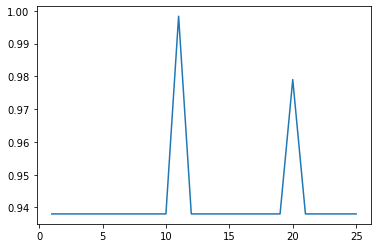

In [199]:
x = feature_level_attack(siamese, X_train[1].reshape(1, -1), np.arange(160), 25)

In [200]:
arr = np.array([[ 59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  17.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  17.,  59.,  59.,  59.,  59.,
         59.,  17.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  17.,  59.,  59.,  59.,  59.,
         59.,  59.,  17.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  17.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  17.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  17.,  59.,  45.,  17.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  17.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  17.,  59.,  59.,  17.,  59.,  59.,  59.,  59.,  59.,  45.,
         17.,  59.,  17.,  59.,  59.,  17.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  17.,  59.,  59.,  59.,
         59.,  59.,  59.,  59.,  17.,  59.,  59.,  59.,  59.,  59.,  17.,
         59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,  59.,
         59.,  59.,  17.,  45.,  17.,  26.,  26.,  21., 159.,  21.,   0.,
          3., 157.,  21.,   3.,  21., 159.,  21.,   0.,  79.,  13.,  66.,
         85.,  23.,  23.,  18.,   7.,  67.,  66.,  67.,  53.,  17.,  85.,
         23.,  23.,  18.]])
siamese.predict([arr.reshape(1, -1), X[-22].reshape(1, -1)])

array([[0.99777824]], dtype=float32)

In [54]:
# train a random forest malware detector
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=66)
rf.fit(X_train, Y_train)

from sklearn.metrics import accuracy_score

print('train acc:', accuracy_score(Y_test, rf.predict(X_test)))

train acc: 0.9490740740740741


In [201]:
rf.predict(arr)

array([0], dtype=uint8)

round  1
-0.10952380952380952
0.0
0.0
0.0
0.0
0.0
0.0
-0.014285714285714285
0.0
0.0
-0.002380952380952381
-0.08095238095238096
0.0
0.0
0.0
0.0
0.0
-0.07857142857142857
-0.1595238095238095
0.0
0.0
-0.13095238095238096
-0.009523809523809525
-0.17857142857142858
-0.023809523809523808
0.0
-0.022857142857142857
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
-0.004761904761904762
0.0
0.0
-0.06666666666666667
-0.07142857142857142
0.0
-0.06666666666666667
-0.002380952380952381
0.0
-0.02142857142857143
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.009523809523809525
0.0
0.0
-0.004761904761904762
-0.3119047619047619
0.0
0.0
0.0
0.0033333333333333335
-0.18333333333333332
-0.002380952380952381
0.0
-0.002380952380952381
-0.15857142857142859
0.0
0.0
-0.05476190476190476
-0.05
0.0
0.006666666666666667
-0.03571428571428571
-0.7585714285714286
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.05714285714285714
0.0
0.0
0.0
0.0
-0.24523809523809523
-0.016666666666666666
-0.004761904761904762
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

-0.009523809523809525
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.002380952380952381
-0.8395238095238096
0.0
0.0
-0.026666666666666665
0.0
0.0
0.0
0.0
0.0
[[0.02 0.98]]
round  8
0.0
-0.002380952380952381
0.0
-0.002380952380952381
0.0
0.0
0.0
-0.002380952380952381
0.004285714285714286
0.0
0.0
-0.005238095238095237
0.0
-0.05476190476190476
0.0
0.0
-0.020476190476190474
-0.047619047619047616
-0.04047619047619048
0.0033333333333333335
0.0
-0.2776190476190476
-0.1
-0.022857142857142857
-0.018095238095238095
-0.009523809523809525
-0.07571428571428572
-0.03333333333333333
-0.0014285714285714288
0.0
-0.002380952380952381
-0.002380952380952381
0.0
-0.002380952380952381
0.0
0.0
-0.003809523809523809
0.0
-0.002380952380952381
-0.009523809523809525
0.0
0.0
0.0
0.0
0.0
-0.016666666666666

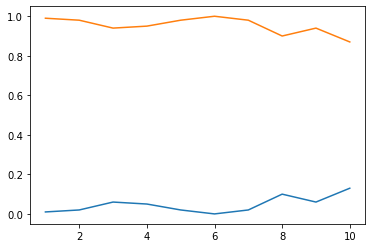

In [158]:
import matplotlib.pyplot as plt

def feature_level_attack(model, x, A, total_round = 10):
    # model: trained model detector
    # x: input api sequence with length l
    # A: set of api call
    r = 1 # round 
    x_star = x
    
    class_0_prob = []
    class_1_prob = []
    
    while(model.predict(x_star) == 1):
        print('round ', r)
        r += 1
        
        i = np.random.randint(0, l-1)
        max_F = 0
        max_idx = 0
        for idx in range(len(A)):
            f = F(B, [x_star[0, i]] + [idx]) - F(M, [x_star[0, i]] + [idx])
            print(f)
            if f > max_F:
                #print(f, max_F)
                max_F = f
                max_idx = idx
                
        
        x_star = np.concatenate((x_star[0, 1:i], [max_idx], x_star[0, i:])).reshape(1, -1)
        #print([x_star])
        prob = model.predict_proba(x_star)
        print(prob)
        class_0_prob.append(prob[0, 0])
        class_1_prob.append(prob[0, 1])
        
        # If the loop doesn't stop after r round, just exit.
        if r == (total_round + 1):
            break
    plt.plot(np.arange(len(class_0_prob)) + 1, class_0_prob)
    plt.plot(np.arange(len(class_1_prob)) + 1, class_1_prob)
    plt.show()
    return x_star

x = feature_level_attack(rf, X_train[5].reshape(1, -1), np.arange(160))

## 12/08紀錄

現在改用 keras 官網提供的 siamese network 的範例，因為這個程式才能做單一 sample 的預測。

然而目前遇到的問題是，由於 siamese network 本身的特性，需要兩兩一組判斷一樣或不一樣。但在這樣的情況下，在生成 AE 的時候，也需要一個 malware 來跟生成中的 AE 做比較，那要誰來當這個 AE? 我暫時隨機選用資料集裡面的 malware。

另一個問題是 siamese network 好像不受這個方法影響。我試過把隨機的 malware 跑 20 次，但 siamese network 預測 class 的值看不出有下降。然而最後得到的 AE 丟進 rf 卻會被當成 benign。